#### Install Python library 'afinn' to score sentiments

In [1]:
#pip install afinn

In [2]:
# Import libraries
import re  # For regular expressions
import nltk  # For text functions
import matplotlib.pyplot as plt  # For plotting
import pandas as pd  # For dataframes
from afinn import Afinn  # For sentiment values

# Import corpora and functions from NLTK
from nltk.corpus import stopwords
from nltk.corpus import opinion_lexicon
from nltk.tokenize import word_tokenize
from nltk.corpus import gutenberg

# Download data for NLTK
nltk.download('stopwords', quiet=True)
nltk.download('opinion_lexicon', quiet=True)
nltk.download('punkt', quiet=True)

# Use Matplotlib style sheet
plt.style.use('ggplot')

#### Prepare data

In [3]:
austen = gutenberg.sents('austen-emma.txt') # can choose another author name from the available choices
rows_list = []
for row in austen:
    if row:
        innerStr = ' '.join([str(elem) for elem in row]) #convert the list to single string
        rows_list.append([str(innerStr)])

df = pd.DataFrame(rows_list, columns= ['text']).dropna()
df.head()

,text
0,[ Emma by Jane Austen 1816 ]
1,VOLUME I
2,CHAPTER I
3,"Emma Woodhouse , handsome , clever , and rich ..."
4,She was the youngest of the two daughters of a...


#### Add Line Numbers to divide text into sections

In [4]:
df['line'] = range(1, len(df) + 1)

df.head()

,text,line
0,[ Emma by Jane Austen 1816 ],1
1,VOLUME I,2
2,CHAPTER I,3
3,"Emma Woodhouse , handsome , clever , and rich ...",4
4,She was the youngest of the two daughters of a...,5


#### Tokenize the Data

In [5]:
def clean_text(text):
    text = text.lower()  # Convert all text to lowercase
    text = text.replace("'", '')
    text = re.sub(r'[^\w]', ' ', text)  # Leave only word characters
    text = re.sub(r'\s+', ' ', text)  # Omit extra space characters
    text = text.strip()
    return text

df['text'] = df['text'].map(clean_text) 
df['text'] = df['text'].map(word_tokenize) # Split text into word tokens

df.head()

,text,line
0,"[emma, by, jane, austen, 1816]",1
1,"[volume, i]",2
2,"[chapter, i]",3
3,"[emma, woodhouse, handsome, clever, and, rich,...",4
4,"[she, was, the, youngest, of, the, two, daught...",5


#### Collect tokens into a single series

In [6]:
df = df.explode('text').rename(columns={'text': 'token'})
df.dropna(subset = ["token"], inplace=True)
df.head(10)

,token,line
0,emma,1
0,by,1
0,jane,1
0,austen,1
0,1816,1
1,volume,2
1,i,2
2,chapter,3
2,i,3
3,emma,4


#### Score sentiments using the AFINN lexicon, which scores words on a scale of -5 (most negative) to +5 (most positive).

In [7]:
afinn_scorer = Afinn()

df['score'] = df['token'].map(afinn_scorer.score).astype(int)
df = df[df['score'] != 0]

#### Show a frequency table for the sentiment scores.

In [8]:
score_freq = df.score.value_counts().sort_index().to_frame('n')

score_freq

,n
-4,1
-3,435
-2,2642
-1,1618
1,1764
2,3413
3,2206
4,44


#### Graph score frequencies

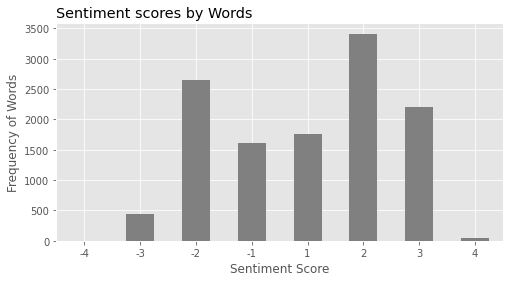

In [9]:
score_freq.plot.bar(
    legend=False,
    figsize=(8, 4),
    grid=True,
    color='gray')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency of Words')
plt.title('Sentiment scores by Words', loc='left')
plt.xticks(rotation=0);

#### Sentiment Arc -  Calculate a sentiment score for every section.

In [10]:
score_acc = df.groupby(df['line'] // 100)\
    .score.mean()\
    .to_frame('score')\
    .rename_axis('section')

score_acc.head(10)

,score
section,
0,0.494845
1,1.062500
2,0.800000
3,0.963235
4,0.805085
5,0.867550
6,1.041096
7,0.409091
8,0.656051


#### Plot Scores of each section to view narrative arc

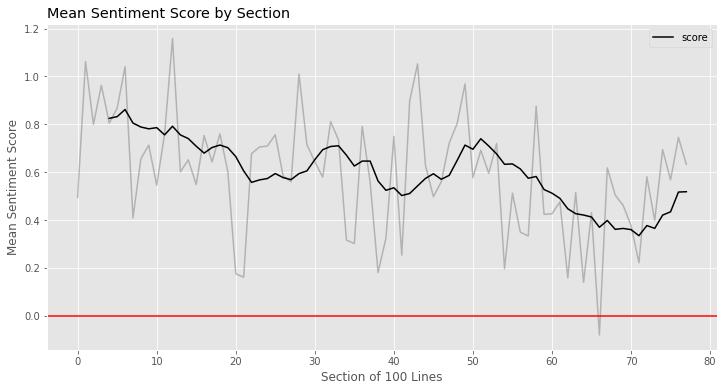

In [11]:
ax = score_acc.plot.line(legend=False, figsize=(12, 6), grid=True, alpha=0.5, color='gray')
score_acc.rolling(10, min_periods=5).mean().plot.line(ax=ax, color='black')
plt.xlabel('Section of 100 Lines')
plt.ylabel('Mean Sentiment Score')
plt.title('Mean Sentiment Score by Section', loc='left')
plt.axhline(0, color='red')
plt.xticks(rotation=0);